In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import torch
import lightning.pytorch as pl

from pathlib import Path
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

2024-04-04 04:32:38.906445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 04:32:38.906485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 04:32:38.907585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 04:32:38.913368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 04:32:39.681188: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("Maldives_data_1.csv")

In [3]:
df['err_vgosa'].fillna(int(df['err_vgosa'].mean()), inplace=True)
df['err_ugosa'].fillna(int(df['err_ugosa'].mean()), inplace=True)

In [4]:
df.head()

,time,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa
0,1993-01-01,0.875,72.875,0.7483,0.0162,0.0,0.0,0.0,-0.0171,0.0061,-0.2200,-0.3054,-0.0533,-0.0791
1,1993-01-01,0.875,73.125,0.7443,0.0171,0.0,0.0,0.0,-0.0216,0.0061,-0.2363,-0.2918,-0.0089,-0.0454
2,1993-01-01,0.875,73.375,0.7455,0.0176,0.0,0.0,0.0,-0.0211,0.0061,-0.2631,-0.2803,0.1029,0.0581
3,1993-01-01,0.875,73.625,0.7508,0.0175,0.0,0.0,0.0,-0.0167,0.0061,-0.3532,-0.3364,0.1147,0.0674
4,1993-01-01,1.125,72.875,0.7471,0.0160,0.0,0.0,0.0,-0.0183,0.0061,-0.2254,-0.2747,0.0434,-0.0082


In [5]:
df['time'] = pd.to_datetime(df['time'])
df = df.groupby('time', as_index=False).mean()


In [6]:
# df = df.groupby('time').mean()
# df["time"] = pd.to_datetime(df["time"])
df["time_idx"] = (df["time"] - df["time"].min()).dt.days

#df['flag_ice'] = df['flag_ice'].astype(str)

In [7]:
df_test = df.iloc[-4000:, :]
df_train = df.iloc[:-2000, :]

In [8]:
df_test

,time,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa,time_idx
7115,2012-06-25,4.0,73.25,0.834694,0.018289,0.054005,0.044252,0.0,0.066555,0.0,0.102941,0.102708,0.008091,-0.032697,7115
7116,2012-06-26,4.0,73.25,0.832906,0.017065,0.051472,0.042899,0.0,0.064757,0.0,0.083844,0.083607,0.010971,-0.029819,7116
7117,2012-06-27,4.0,73.25,0.832719,0.015435,0.047782,0.041709,0.0,0.064573,0.0,0.065201,0.064961,0.017305,-0.023476,7117
7118,2012-06-28,4.0,73.25,0.833075,0.013763,0.043689,0.040829,0.0,0.064929,0.0,0.047855,0.047613,0.020590,-0.020192,7118
7119,2012-06-29,4.0,73.25,0.833434,0.012599,0.040481,0.040529,0.0,0.065289,0.0,0.031941,0.031706,0.034063,-0.006718,7119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11110,2023-06-03,4.0,73.25,0.861658,0.012998,0.041313,0.040346,0.0,0.093507,0.0,0.081658,0.081419,-0.045218,-0.086004,11110
11111,2023-06-04,4.0,73.25,0.860913,0.012910,0.041553,0.040205,0.0,0.092765,0.0,0.081892,0.081655,-0.050830,-0.091613,11111
11112,2023-06-05,4.0,73.25,0.858514,0.012727,0.041506,0.039210,0.0,0.090363,0.0,0.079321,0.079082,-0.045461,-0.086249,11112
11113,2023-06-06,4.0,73.25,0.856376,0.012587,0.041400,0.038265,0.0,0.088230,0.0,0.077612,0.077375,-0.044802,-0.085580,11113


In [9]:
max_prediction_length = 2000
max_encoder_length = 2000

training_cutoff = df_train["time_idx"].max() - max_prediction_length

time_varying_known_reals = ['time_idx','flag_ice','vgos', 'ugosa', 'err_ugosa', 'vgosa', 'err_vgosa','sla', 'adt', 'ugos']
time_varying_unknown_reals = ['err_sla']


training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="err_sla",
    group_ids=["latitude", "longitude"],
    categorical_encoders={
         "latitude": NaNLabelEncoder(add_nan=True).fit(df["latitude"]),
         "longitude": NaNLabelEncoder(add_nan=True).fit(df["longitude"])
     },
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["latitude","longitude"],
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


testing = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 2000],
    time_idx="time_idx",
    target="err_sla",
    group_ids=["latitude", "longitude"],
    categorical_encoders={
         "latitude": NaNLabelEncoder(add_nan=True).fit(df["latitude"]),
         "longitude": NaNLabelEncoder(add_nan=True).fit(df["longitude"])
     },
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["latitude","longitude"],
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(testing, df_test, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 40  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [10]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.0039, device='cuda:0')

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming baseline_predictions.y and baseline_predictions.output are your tensors
# First, move tensors to the CPU and convert them to NumPy arrays
actuals = baseline_predictions.y[0].cpu().detach().numpy()
predictions = baseline_predictions.output.cpu().detach().numpy()

# Calculate MSE
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate MAPE
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 1.8545882994658314e-05
Mean Absolute Percentage Error (MAPE): 27.82527804374695%


In [12]:
baseline_predictions = Baseline().predict(test_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.0015, device='cuda:0')

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming baseline_predictions.y and baseline_predictions.output are your tensors
# First, move tensors to the CPU and convert them to NumPy arrays
actuals = baseline_predictions.y[0].cpu().detach().numpy()
predictions = baseline_predictions.output.cpu().detach().numpy()

# Calculate MSE
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate MAPE
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 3.867611212626798e-06
Mean Absolute Percentage Error (MAPE): 9.70228686928749%


In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=2, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.06,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
#{'gradient_clip_val': 0.011513503769288051, 'hidden_size': 35, 'dropout': 0.14677661572735684, 'hidden_continuous_size': 18, 'attention_head_size': 1, 'learning_rate': 0.006695825026121554}

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 32.4k


In [15]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
   
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lst

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 2 records. Best score: 0.000. Signaling Trainer to stop.


In [17]:
import torch
import gc

# Manually clear cache and run garbage collector
torch.cuda.empty_cache()
gc.collect()


63951

In [16]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)


tensor(0.0006)

In [18]:

# Assuming baseline_predictions.y and baseline_predictions.output are your tensors
# First, move tensors to the CPU and convert them to NumPy arrays
actuals = predictions.y[0].cpu().detach().numpy()
predictions = predictions.output.cpu().detach().numpy()

# Calculate MSE
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate MAPE
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 6.680798492197937e-07
Mean Absolute Percentage Error (MAPE): 3.9277207106351852%


In [19]:
predictions = best_tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(0.0015)

In [20]:

# Assuming baseline_predictions.y and baseline_predictions.output are your tensors
# First, move tensors to the CPU and convert them to NumPy arrays
actuals = predictions.y[0].cpu().detach().numpy()
predictions = predictions.output.cpu().detach().numpy()

# Calculate MSE
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate MAPE
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 3.379595000296831e-06
Mean Absolute Percentage Error (MAPE): 10.804876685142517%


In [21]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


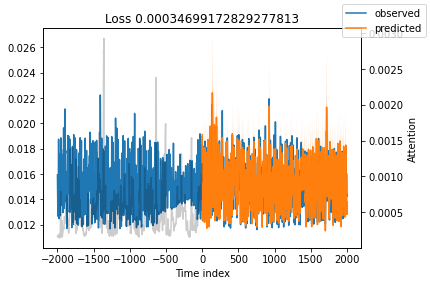

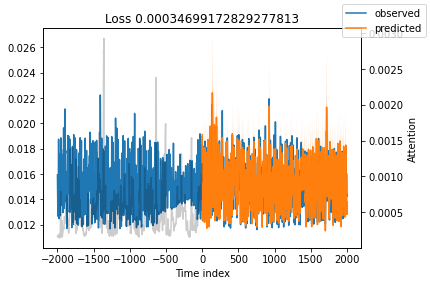

In [22]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

In [23]:
df["time"] = pd.to_datetime(df["time"])
df["time_idx"] = (df["time"] - df["time"].min()).dt.days

In [25]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = df[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
     [last_data.assign(time=lambda x: x.time + pd.offsets.Day(i)) for i in range(1, max_prediction_length + 1)],
     ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (decoder_data["time"] - decoder_data["time"].min()).dt.days
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# # adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [26]:
new_prediction_data

,time,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa,time_idx
0,2017-12-16,4.0,73.25,0.803222,0.014484,0.043463,0.037872,0.0,0.035070,0.0,-0.066050,-0.066286,0.100293,0.059507,9115
1,2017-12-17,4.0,73.25,0.801598,0.014562,0.045202,0.038429,0.0,0.033455,0.0,-0.077325,-0.077560,0.119237,0.078447,9116
2,2017-12-18,4.0,73.25,0.799764,0.014569,0.046453,0.039441,0.0,0.031611,0.0,-0.087590,-0.087833,0.127279,0.086493,9117
3,2017-12-19,4.0,73.25,0.798740,0.014519,0.046981,0.040786,0.0,0.030594,0.0,-0.098046,-0.098279,0.125068,0.084288,9118
4,2017-12-20,4.0,73.25,0.796725,0.014403,0.046912,0.041972,0.0,0.028582,0.0,-0.101471,-0.101712,0.136563,0.095782,9119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2028-11-23,4.0,73.25,0.854349,0.012604,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,13110
3996,2028-11-24,4.0,73.25,0.854349,0.012604,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,13111
3997,2028-11-25,4.0,73.25,0.854349,0.012604,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,13112
3998,2028-11-26,4.0,73.25,0.854349,0.012604,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,13113


In [27]:
max_prediction_length = 2000
max_encoder_length = 2000

time_varying_known_reals = ['time_idx','flag_ice','err_sla', 'ugosa', 'err_ugosa', 'vgosa', 'err_vgosa','sla', 'adt', 'vgos']
time_varying_unknown_reals = ['ugos']





new = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 2000],
    time_idx="time_idx",
    target="ugos",
    group_ids=["latitude", "longitude"],
    categorical_encoders={
         "latitude": NaNLabelEncoder(add_nan=True).fit(new_prediction_data["latitude"]),
         "longitude": NaNLabelEncoder(add_nan=True).fit(new_prediction_data["longitude"])
     },
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["latitude","longitude"],
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

new_pred = TimeSeriesDataSet.from_dataset(new, new_prediction_data, predict=True, stop_randomization=True)

new_pred = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


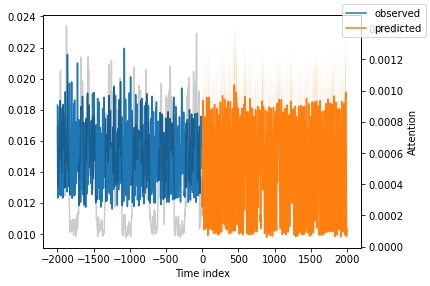

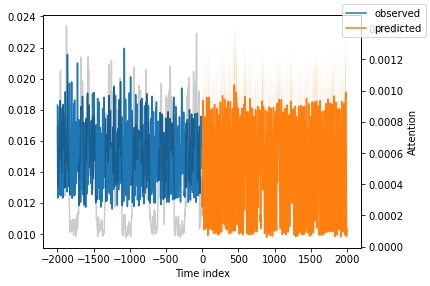

In [28]:
new_raw_predictions = best_tft.predict(new_pred, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False)

In [29]:
sla_outputs = best_tft.predict(new_pred, return_y=False, trainer_kwargs=dict(accelerator="cpu"))

In [30]:
k=sla_outputs.numpy()

In [31]:
k = k.tolist()

In [32]:
len(k[0])

2000

In [33]:
new_prediction_data['err_sla'][2000:4000] = k[0]

In [34]:
# Assuming df is your DataFrame with 'time' and 'sea_level' columns
# Convert 'time' column to datetime
new_prediction_data['time'] = pd.to_datetime(new_prediction_data['time'])

# Extract year from the datetime objects
new_prediction_data['year'] = new_prediction_data['time'].dt.year

# Group by year and calculate the mean sea level for each year
new_prediction_data = new_prediction_data.groupby('year').mean()
new_prediction_data

,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa,time_idx
year,,,,,,,,,,,,,,
2017,4.0,73.25,0.803800,0.015638,0.048016,0.041316,0.0,0.035652,0.0,-0.143915,-0.144153,0.153791,0.113009,9122.5
2018,4.0,73.25,0.838342,0.014764,0.045652,0.040315,0.0,0.070194,0.0,-0.013998,-0.014237,0.043694,0.002911,9313.0
2019,4.0,73.25,0.879908,0.015329,0.047085,0.040922,0.0,0.111760,0.0,-0.024627,-0.024865,0.029441,-0.011342,9678.0
2020,4.0,73.25,0.888170,0.015059,0.046551,0.041136,0.0,0.120022,0.0,0.023196,0.022957,0.016018,-0.024766,10043.5
2021,4.0,73.25,0.887671,0.014774,0.046116,0.040492,0.0,0.119523,0.0,-0.002797,-0.003036,0.069551,0.028768,10409.0
2022,4.0,73.25,0.853626,0.014792,0.046180,0.040703,0.0,0.085478,0.0,0.011852,0.011613,0.067559,0.026775,10774.0
2023,4.0,73.25,0.862416,0.014407,0.043606,0.039118,0.0,0.094267,0.0,-0.026672,-0.026910,0.024592,-0.016191,11139.0
2024,4.0,73.25,0.854349,0.014099,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,11504.5
2025,4.0,73.25,0.854349,0.014238,0.041488,0.038035,0.0,0.086199,0.0,0.075947,0.075710,-0.040992,-0.081775,11870.0


In [35]:
# Specify your Excel file name
file_name = 'ERR_SLA_predictions.xlsx'

# Export DataFrame to Excel
new_prediction_data.to_excel(file_name, index=False)

print(f'DataFrame is written to Excel File successfully.')


DataFrame is written to Excel File successfully.
